<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [307]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [308]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [309]:
# Load the data
house = pd.read_csv('./housing.csv')
# only residential:
house = house[house['MSZoning'].isin(['RH','RL','RP','RM'])]

In [310]:
# A:
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 1500)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [311]:
house.shape

(1385, 81)

In [312]:
house[house.columns[house.isna().any()].tolist()].isnull().sum().sort_values(ascending=False)
# Looking at the definitions, these cols have NaNs when =0, e.g. No pool, No Alley, No Bsmt...
# except for Electrical, MasVnrArea, MasVnrType, LotFrontage

# Data needs to be cleaned thoroughly otherwise we can't regress these columns, and we can't dummify them either.

PoolQC          1378
MiscFeature     1333
Alley           1320
Fence           1108
FireplaceQu      641
LotFrontage      251
GarageYrBlt       79
GarageType        79
GarageFinish      79
GarageQual        79
GarageCond        79
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         5
MasVnrType         5
Electrical         1
dtype: int64

In [313]:
# Most of the NaNs represent None, so will map to that
# one BsmtFinType2 will be mapped to Unf (as vast majority is Unf), 
# one BsmtExposure will be mapped to No having looked at those cols.
# the overwhelming majority of Electrical types are SBrkr so will map the NaN to that:...

In [314]:
# Data Cleaning: at the end I will map all to 'None', first I will map those few that don't fit that criteria
# to their more appropriate overrides:
house['Electrical'].fillna('SBrkr', inplace=True)
house['MasVnrArea'].fillna(0, inplace=True)
house['GarageYrBlt'].fillna(0, inplace=True)
house['MasVnrType'].fillna('None', inplace=True)
house['BsmtFinType2'][(house['BsmtFinType2'].isna()) & (house['BsmtFinType1'].notna())].fillna('Unf', inplace=True)
house['BsmtExposure'][(house['BsmtExposure'].isna()) & (house['BsmtFinType1'].notna())].fillna('No', inplace=True)

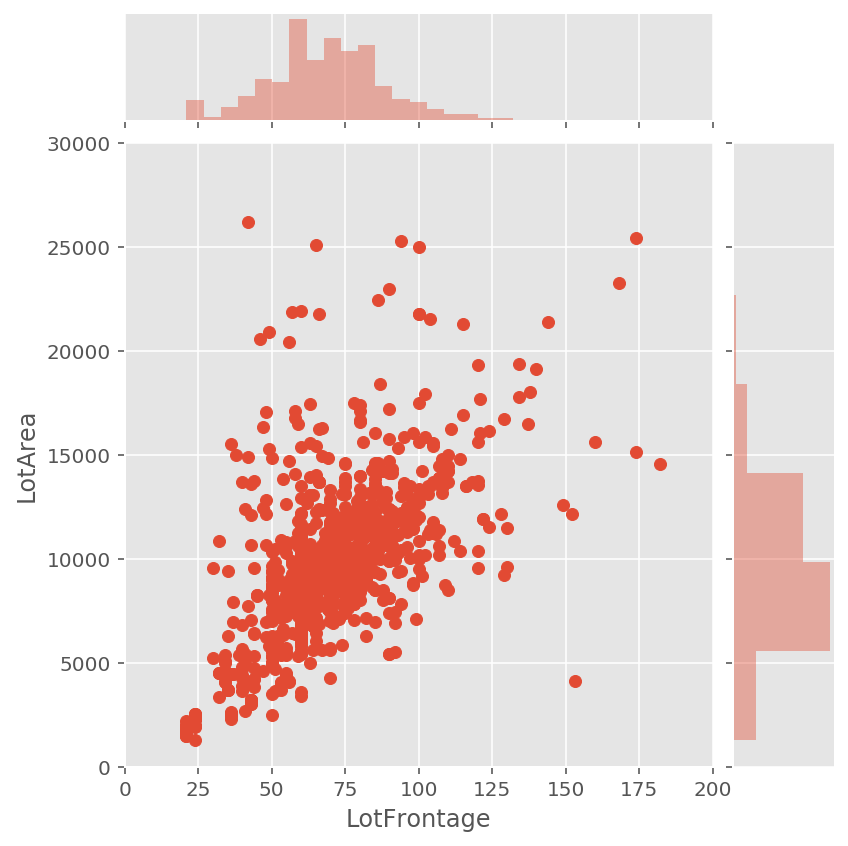

In [315]:
# Can NaNs in LotFrontage be implied from LotArea? It would seem we can model this judging from the plot:
sns.jointplot(house.LotFrontage, house.LotArea, xlim=(0,200), ylim=(0,30000));

In [316]:
# Linear Regression model:
# Specify the predictor and target variables, needs to be on notna() portion for regression to run.
# I will also remove outliers to improve the model's regression:
X = house[['LotArea','YrSold']][(house['LotFrontage'].notna()) & (house['LotFrontage'] < 125) & (house['LotArea'] < 15000)]
y = house[['LotFrontage','YrSold']][(house['LotFrontage'].notna()) & (house['LotFrontage'] < 125) & (house['LotArea'] < 15000)]

In [317]:
# Perform train-test-split (recall: we're asked here to train on pre-2010 and test on 2010 data
# so I will assume no knowledge of 2010 data when estimating the missing LotFrontages):
X_train = X[['LotArea']][X['YrSold'] != 2010]
X_test = X[['LotArea']][X['YrSold'] == 2010]
y_train = y[['LotFrontage']][y['YrSold'] != 2010]
y_test = y[['LotFrontage']][y['YrSold'] == 2010]

In [318]:
house.YrSold.value_counts()     # Note - this implies test_size = 11% train=pre-2010 data

2009    321
2007    313
2006    299
2008    288
2010    164
Name: YrSold, dtype: int64

In [319]:
# Fit linear regression.
# create a linear regression model instance:
model = LinearRegression()

# get cross validated scores
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(model, X_train, y_train, cv=kf)
print("Cross-validated training scores:", scores)
print("Mean() of cv training score:", scores.mean())
print("Std() of cv training score:", scores.std())

# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))

# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [0.49339214 0.47716555 0.57568347 0.50761334 0.45405505]
Mean() of cv training score: 0.5015819098538461
Std() of cv training score: 0.041108276711432475
Training Score: 0.5066728693421098
Test Score: 0.44546619484823946


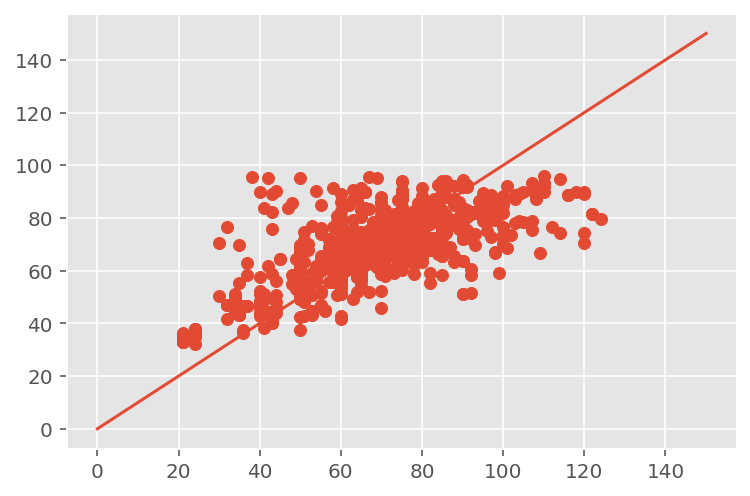

In [320]:
# create predictions, and plot vs y
yhat = model.predict(X_train)
plt.scatter(y_train, yhat);
plt.plot([0,150],[0,150]);

# doesn't perform too badly, it's a passable way to approximate for missing LotFrontage data:

In [321]:
# Data Cleaning 2: apply the model to LotFrontage...
house['LotFrontage'] = house.apply(lambda x: round(np.float((model.coef_ * x['LotArea']) + model.intercept_),0)
                                                     if pd.isnull(x['LotFrontage']) else x['LotFrontage'], axis=1)

In [322]:
house[['LotArea','LotFrontage']]     # no more Nan's in LotFrontage now.

,LotArea,LotFrontage
0,8450,65.0
1,9600,80.0
2,11250,68.0
3,9550,60.0
4,14260,84.0
5,14115,85.0
6,10084,75.0
7,10382,74.0
8,6120,51.0
9,7420,50.0


In [323]:
# double-check if simply squaring LotFrontage would have given a better LotArea estimate than the regression
lot = house[['LotArea','LotFrontage']]
lot['LotFrontageSq'] = lot.apply(lambda x: x['LotFrontage']**2, axis=1)
lot['Diff'] = lot.apply(lambda x: x['LotArea']-x['LotFrontageSq'], axis=1)
lot['Diff%'] = lot.apply(lambda x: 100*x['Diff']/x['LotArea'], axis=1)
lot

# No... squaring LotFrontage is a poor estimator:

/Users/Noah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Noah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Noah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,LotArea,LotFrontage,LotFrontageSq,Diff,Diff%
0,8450,65.0,4225.0,4225.0,50.0
1,9600,80.0,6400.0,3200.0,33.3
2,11250,68.0,4624.0,6626.0,58.9
3,9550,60.0,3600.0,5950.0,62.3
4,14260,84.0,7056.0,7204.0,50.5
5,14115,85.0,7225.0,6890.0,48.8
6,10084,75.0,5625.0,4459.0,44.2
7,10382,74.0,5476.0,4906.0,47.3
8,6120,51.0,2601.0,3519.0,57.5
9,7420,50.0,2500.0,4920.0,66.3


In [324]:
# Data Cleaning 3: change all remaining nan's to 'None':
house.fillna('None',inplace=True)    # done with the data cleaning.

In [325]:
house[house.columns[house.isna().any()].tolist()].isnull().sum().sort_values(ascending=False)
# checking no more NaNs:

Series([], dtype: float64)

In [326]:
# plt.figure(figsize=(24,20))
# sns.heatmap(house.corr(),vmin=-1,vmax=1,annot=True, fmt='0.0');  # need to dummify the categorical variables: 
# they're ommited from the heatmap (and also will obviously need to standardize after)

In [327]:
# but first need to separate out fixed characteristics we're interested in as it will be difficult to select
# from columns once they have been dummified:

In [328]:
# I will need to create a simple data dictionary, which tags columns as Fixed or Changeable:
house_dictionary = {'Fixed': ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
                              'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                              'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'Foundation',
                              'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
                              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                              'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt', 'GarageCars',
                              'GarageArea', 'PoolArea', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
                              'SaleCondition'],
                    'Changeable': ['OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
                                  'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
                                  'ExterCond', 'BsmtCond','BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                                  'LowQualFinSF', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu',
                                  'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
                                  'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'Fence'],
                   'SalePrice': ['SalePrice']}

In [359]:
# Now we can split fixed vs changeable:
X_fixed = house[house_dictionary['Fixed']]
X_changeable = pd.concat([house[house_dictionary['Changeable']],house['YrSold']],axis=1)
y = house[house_dictionary['SalePrice']]

In [330]:
# Let's redo the heatmap only on Fixed characteristics:
# plt.figure(figsize=(24,20))
# sns.heatmap(pd.concat([X_fixed,y],axis=1).corr(),vmin=-1,vmax=1,annot=True, fmt='0.0');

In [331]:
# Dummifying variables - you want to dummify only those variables with a few categories and could be predictive:
# Choosing:...

In [332]:
X_fixed.select_dtypes(include=['object']).nunique()

MSZoning          3
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
Foundation        6
BsmtQual          5
BsmtExposure      5
GarageType        7
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64

In [333]:
# only Neighborhood has a high nunique() counts, so perhaps doesn't need dummifying?
Neighborhood = house[['Neighborhood','SalePrice']].groupby('Neighborhood').mean().reset_index().sort_values('SalePrice')

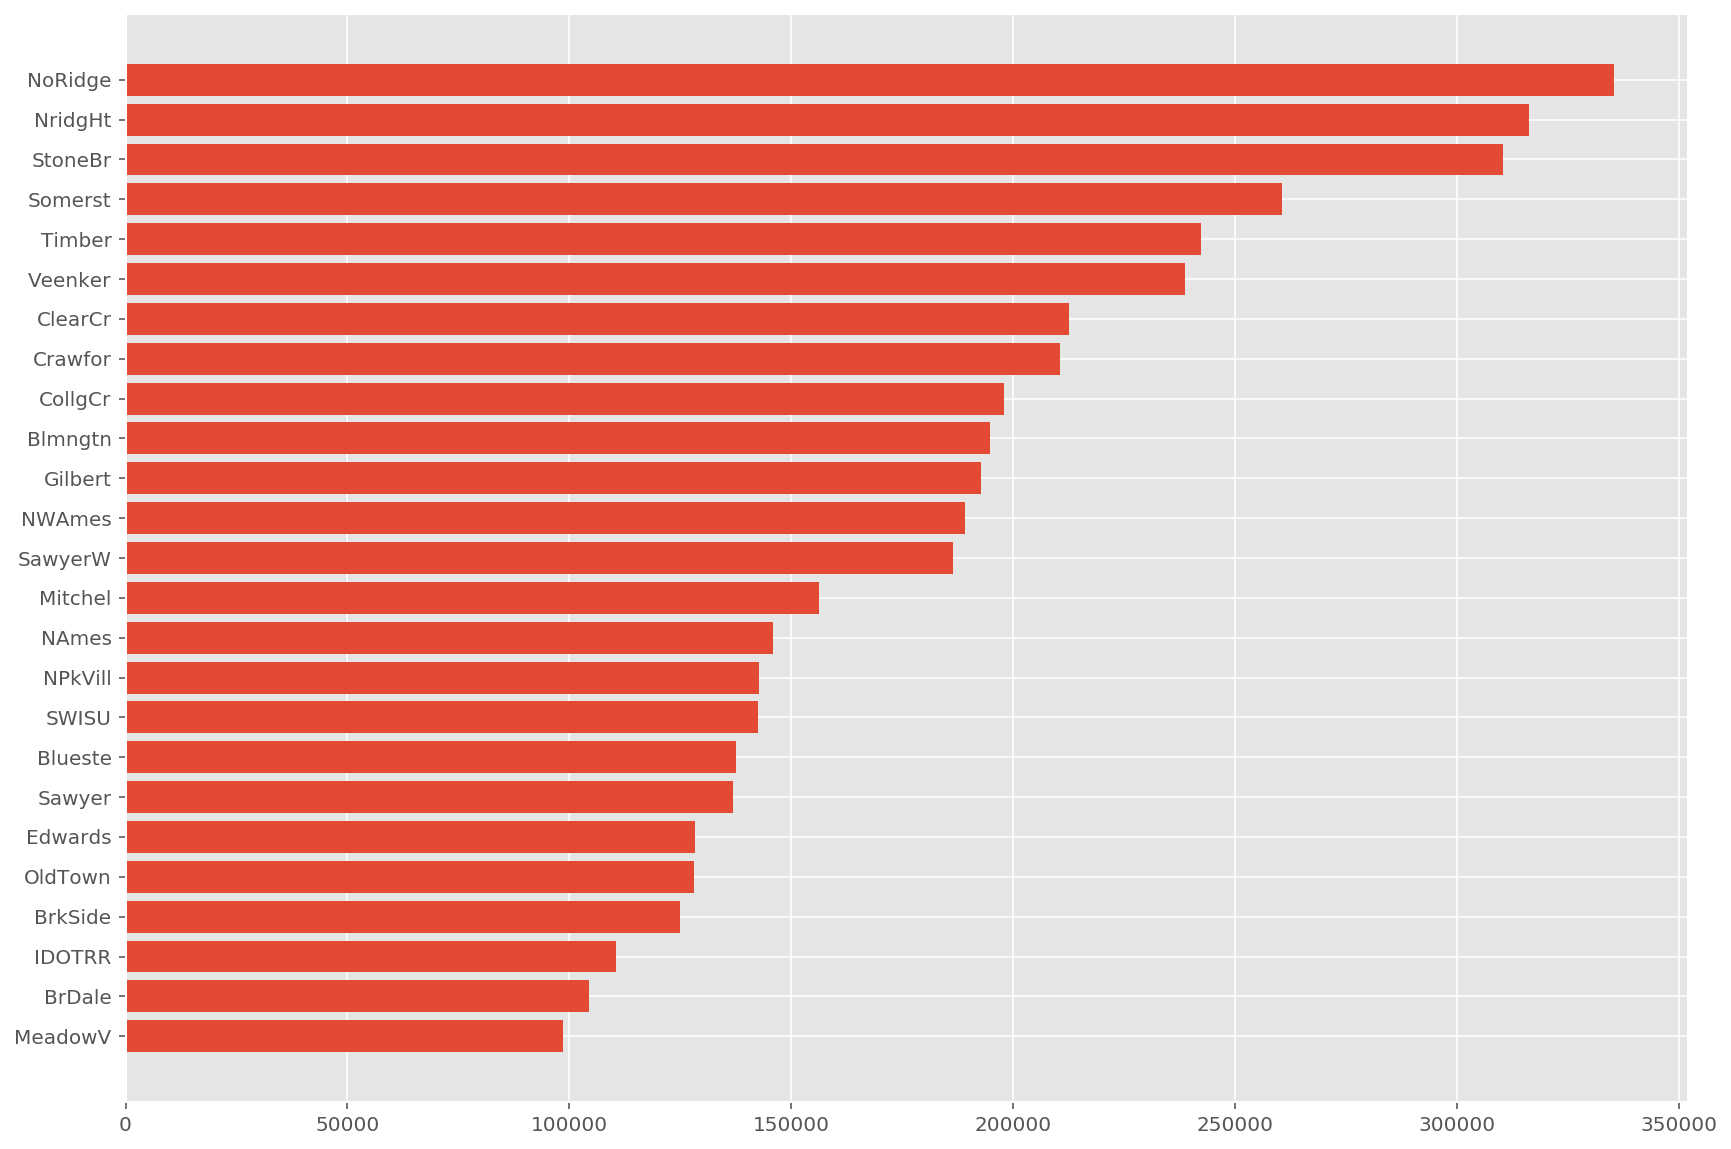

In [334]:
plt.figure(figsize=(14,10))
plt.barh(Neighborhood.Neighborhood, Neighborhood.SalePrice);

# Neighborhood is the only categorical data in X_fixed that has many possible outcomes, but still needs to 
# be dummified as it appears to be predictive of Sale Price:

In [335]:
# So let's dummify all the categorical variables:
X_fixed_dum = pd.get_dummies(X_fixed, drop_first=True)

In [336]:
# Modelling: Set X and y, train-test-split, standardize X, then regress only on fixed X, then elastic-net:
X = X_fixed_dum.copy()
# y was already set above

In [337]:
house_temp = pd.concat([X,y],axis=1)
house_temp.head()

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,PoolArea,MiscVal,MoSold,YrSold,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,65.0,8450,2003,856,856,854,1710,1,0,2,1,3,1,8,2003.0,2,548,0,0,2,2008,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,208500
1,2,20,80.0,9600,1976,1262,1262,0,1262,0,1,2,0,3,1,6,1976.0,2,460,0,0,5,2007,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,181500
2,3,60,68.0,11250,2001,920,920,866,1786,1,0,2,1,3,1,6,2001.0,2,608,0,0,9,2008,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,223500
3,4,70,60.0,9550,1915,756,961,756,1717,1,0,1,0,3,1,7,1998.0,3,642,0,0,2,2006,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,140000
4,5,60,84.0,14260,2000,1145,1145,1053,2198,1,0,2,1,4,1,9,2000.0,3,836,0,0,12,2008,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,250000


In [338]:
# Recall question asked us to train on pre-2010, and test on 2010 data (this means test_size ~11%)b:
y_train = house_temp[house_temp['YrSold'] != 2010]['SalePrice']
y_test = house_temp[house_temp['YrSold'] == 2010]['SalePrice']
X_train = X[X['YrSold'] != 2010]
X_test = X[X['YrSold'] == 2010]

In [339]:
# Then standardize the new 2010 splits:
scaler = StandardScaler()    # instantiate the StandardScaler class

X_train_std = scaler.fit_transform(X_train)     # call .fit_transform() method on X_train
X_train = pd.DataFrame(X_train_std,columns=X_train.columns, index=X_train.index)     # turn the standardized data into a dataframe

# For X_test, make sure to only 'transform' not 'fit_transform'!
X_test_std = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_std,columns=X_test.columns, index=X_test.index)

In [340]:
# Now we model:
slr = LinearRegression()
slr.fit(X_train,y_train)

print(slr.score(X_train,y_train))
print(slr.score(X_test,y_test))

# we get very stable R^2 for train and test.

0.8633762884360999
0.8778613041986061


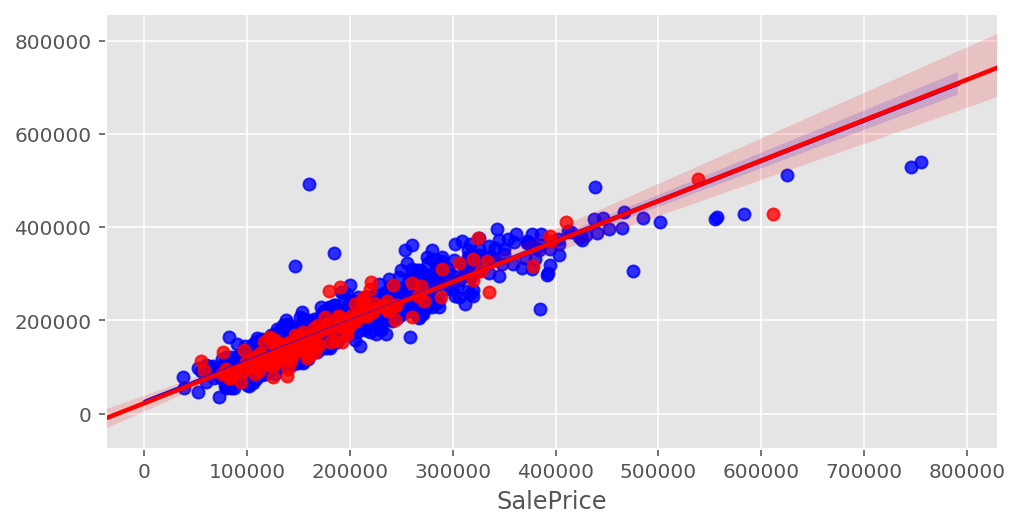

In [341]:
# plot predict vs y:
fig, ax = plt.subplots(figsize=(8,4))
sns.regplot(y_train, slr.predict(X_train), color='b')
sns.regplot(y_test, slr.predict(X_test), color='r')

In [342]:
# check with cross_val_score:
scores = cross_val_score(slr, X_train, y_train, cv=kf)
print(scores)
print(np.mean(scores))

[-3.90651778e+25 -1.21134440e+24  7.38200784e-01 -1.84669213e+24
 -8.37986738e+23]
-8.592240220727196e+24


In [343]:
# initiate the betas df:
betas = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(slr.coef_)],axis=1)
betas.columns = ['X_train','slr model.coef_']
betas

,X_train,slr model.coef_
0,Id,-518.9
1,MSSubClass,-3177.7
2,LotFrontage,-5760.9
3,LotArea,9541.6
4,YearBuilt,7711.8
5,TotalBsmtSF,1990.6
6,1stFlrSF,11512.4
7,2ndFlrSF,21595.9
8,GrLivArea,15325.7
9,BsmtFullBath,5382.3


In [344]:
# Now see if we can improve betas with regularization:
elastic = ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     alphas=np.logspace(-5, 5, 100), cv=kf, max_iter=10000)
elastic.fit(X_train, y_train)
print(elastic.alpha_)
print(elastic.l1_ratio_)

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24835837738.28064, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290998344154.565, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398823295534.1296, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303051372454.9326, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303012678750.70557, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302980882580.7622, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8569783341.319214, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332771995130.9856, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454309732379.28705, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420610711719.6982, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420592834570.40985, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420577966291.96014, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301664311067.0419, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302629934415.82214, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302909506977.1157, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381601350352.47266, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381581258057.5379, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381565050212.44073, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420314900433.36993, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420402639542.5553, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420443501786.38947, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160307139814.47464, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255531196395.66168, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286830669377.6167, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381632269389.34174, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381604806441.5888, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381582167220.31415, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418135532848.28125, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418780143682.6886, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419163710445.70703, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254980025349.75504, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277019392058.13104, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287447342704.7264, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381374942595.2404, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381371592117.5566, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15183908802.03186, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 411299595692.06836, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412082924102.0639, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412657518550.73676, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262250455160.20584, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268828272995.4502, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 273359401873.65817, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1261268336.8155518, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13059290532.25061, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61414471813.80786, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355010124529.1558, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358598618984.9018, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361324886571.1247, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111506072277.39838, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152476827347.05783, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183845402011.8715, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377325896364.8327, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377566720978.8811, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377747194563.6832, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108482434964.09479, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151942048137.09918, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189257110642.25598, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234799710029.70078, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238387606843.6884, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241212788175.69415, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188462344677.71616, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188958683404.57898, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6894569787.296753, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20854592933.020508, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46481118924.56152, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80695506738.54565, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109269140452.40417, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120560445039.59363, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129870647390.33484, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150941862863.87976, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153290687073.2281, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155158273168.63647, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123690648512.43701, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124251415453.84985, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124696098399.51855, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356406414065.2152, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356531125063.6584, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356629569167.73254, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1669557078.3781738, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4235070543.125122, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8624852899.305298, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11343066722.80481, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13389954006.48291, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15245471217.798096, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9412035147.886353, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11128600434.883667, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12684630211.87976, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170501707971.21094, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194162268132.13583, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212632894555.22943, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3070527378.565918, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5116323343.869019, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7605484434.124634, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1797853593.4764404, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2449942133.766968, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3125447866.5039062, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

23.10129700083158
0.99


In [345]:
print(elastic.alpha_)
print(elastic.l1_ratio_)
# Not much regularization applied / needed

23.10129700083158
0.99


In [346]:
print('ElasticNet Train score: ', elastic.score(X_train, y_train))
print('ElasticNet Test score: ', elastic.score(X_test, y_test))

ElasticNet Train score:  0.8449153704686889
ElasticNet Test score:  0.8660285115720469


In [347]:
enet = ElasticNet(alpha=elastic.alpha_, l1_ratio=elastic.l1_ratio_)
enet_scores = cross_val_score(enet, X_train, y_train, cv=kf)

print(enet_scores)
print(np.mean(enet_scores))
print(np.std(enet_scores))

# the CV score is now much more stable following the regularization:

[0.82775069 0.67919796 0.75928101 0.89266743 0.83715461]
0.7992103397530302
0.0734654583471305


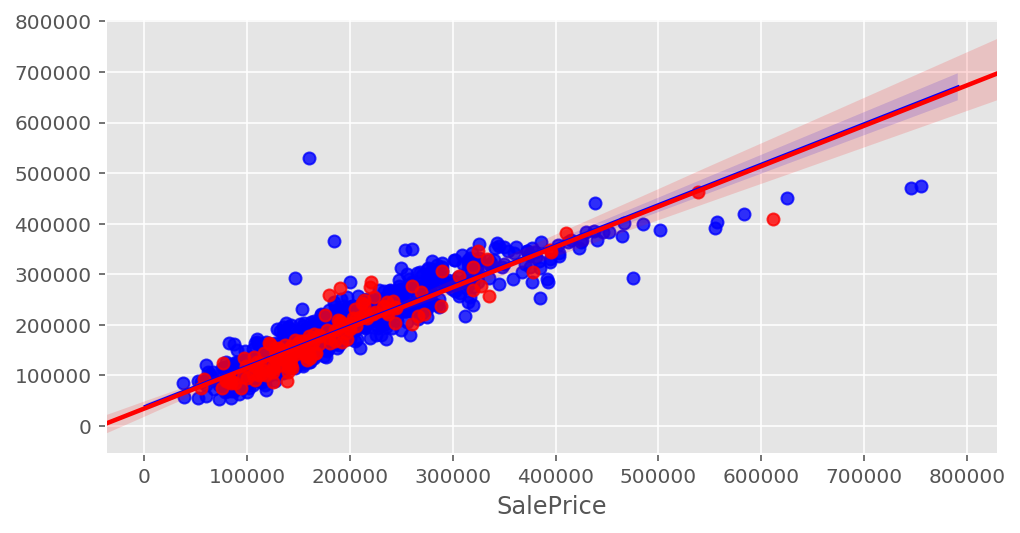

In [348]:
fig, ax = plt.subplots(figsize=(8,4))
sns.regplot(y_train, elastic.predict(X_train), color='b')
sns.regplot(y_test, elastic.predict(X_test), color='r')

In [349]:
# appending SalePrice.corr() with predictor variables
betas = betas.set_index('X_train')
SalePrice_corr = pd.concat([X,y],axis=1).corr()[['SalePrice']].drop('SalePrice')
betas['SalePrice_corr'] = SalePrice_corr
betas['abs SalePrice_corr'] = betas['SalePrice_corr'].abs()
betas.sort_values('abs SalePrice_corr',ascending=False)

# appending ElasticNet betas
betas['ElasticNet model.coef_'] = elastic.coef_
betas['abs ElasticNet model.coef_'] = betas['ElasticNet model.coef_'].abs()

In [350]:
# visualising betas:
betas.sort_values('abs SalePrice_corr', ascending=False, inplace=True)
betas

,slr model.coef_,SalePrice_corr,abs SalePrice_corr,ElasticNet model.coef_,abs ElasticNet model.coef_
X_train,,,,,
GrLivArea,15325.7,0.7,0.7,12365.5,12365.5
GarageCars,11464.3,0.6,0.6,7162.2,7162.2
GarageArea,-1524.3,0.6,0.6,4162.3,4162.3
TotalBsmtSF,1990.6,0.6,0.6,6362.5,6362.5
1stFlrSF,11512.4,0.6,0.6,8525.3,8525.3
FullBath,4949.0,0.6,0.6,5611.0,5611.0
TotRmsAbvGrd,4465.7,0.5,0.5,6221.6,6221.6
YearBuilt,7711.8,0.5,0.5,5243.8,5243.8
Foundation_PConc,3513.0,0.5,0.5,3015.6,3015.6


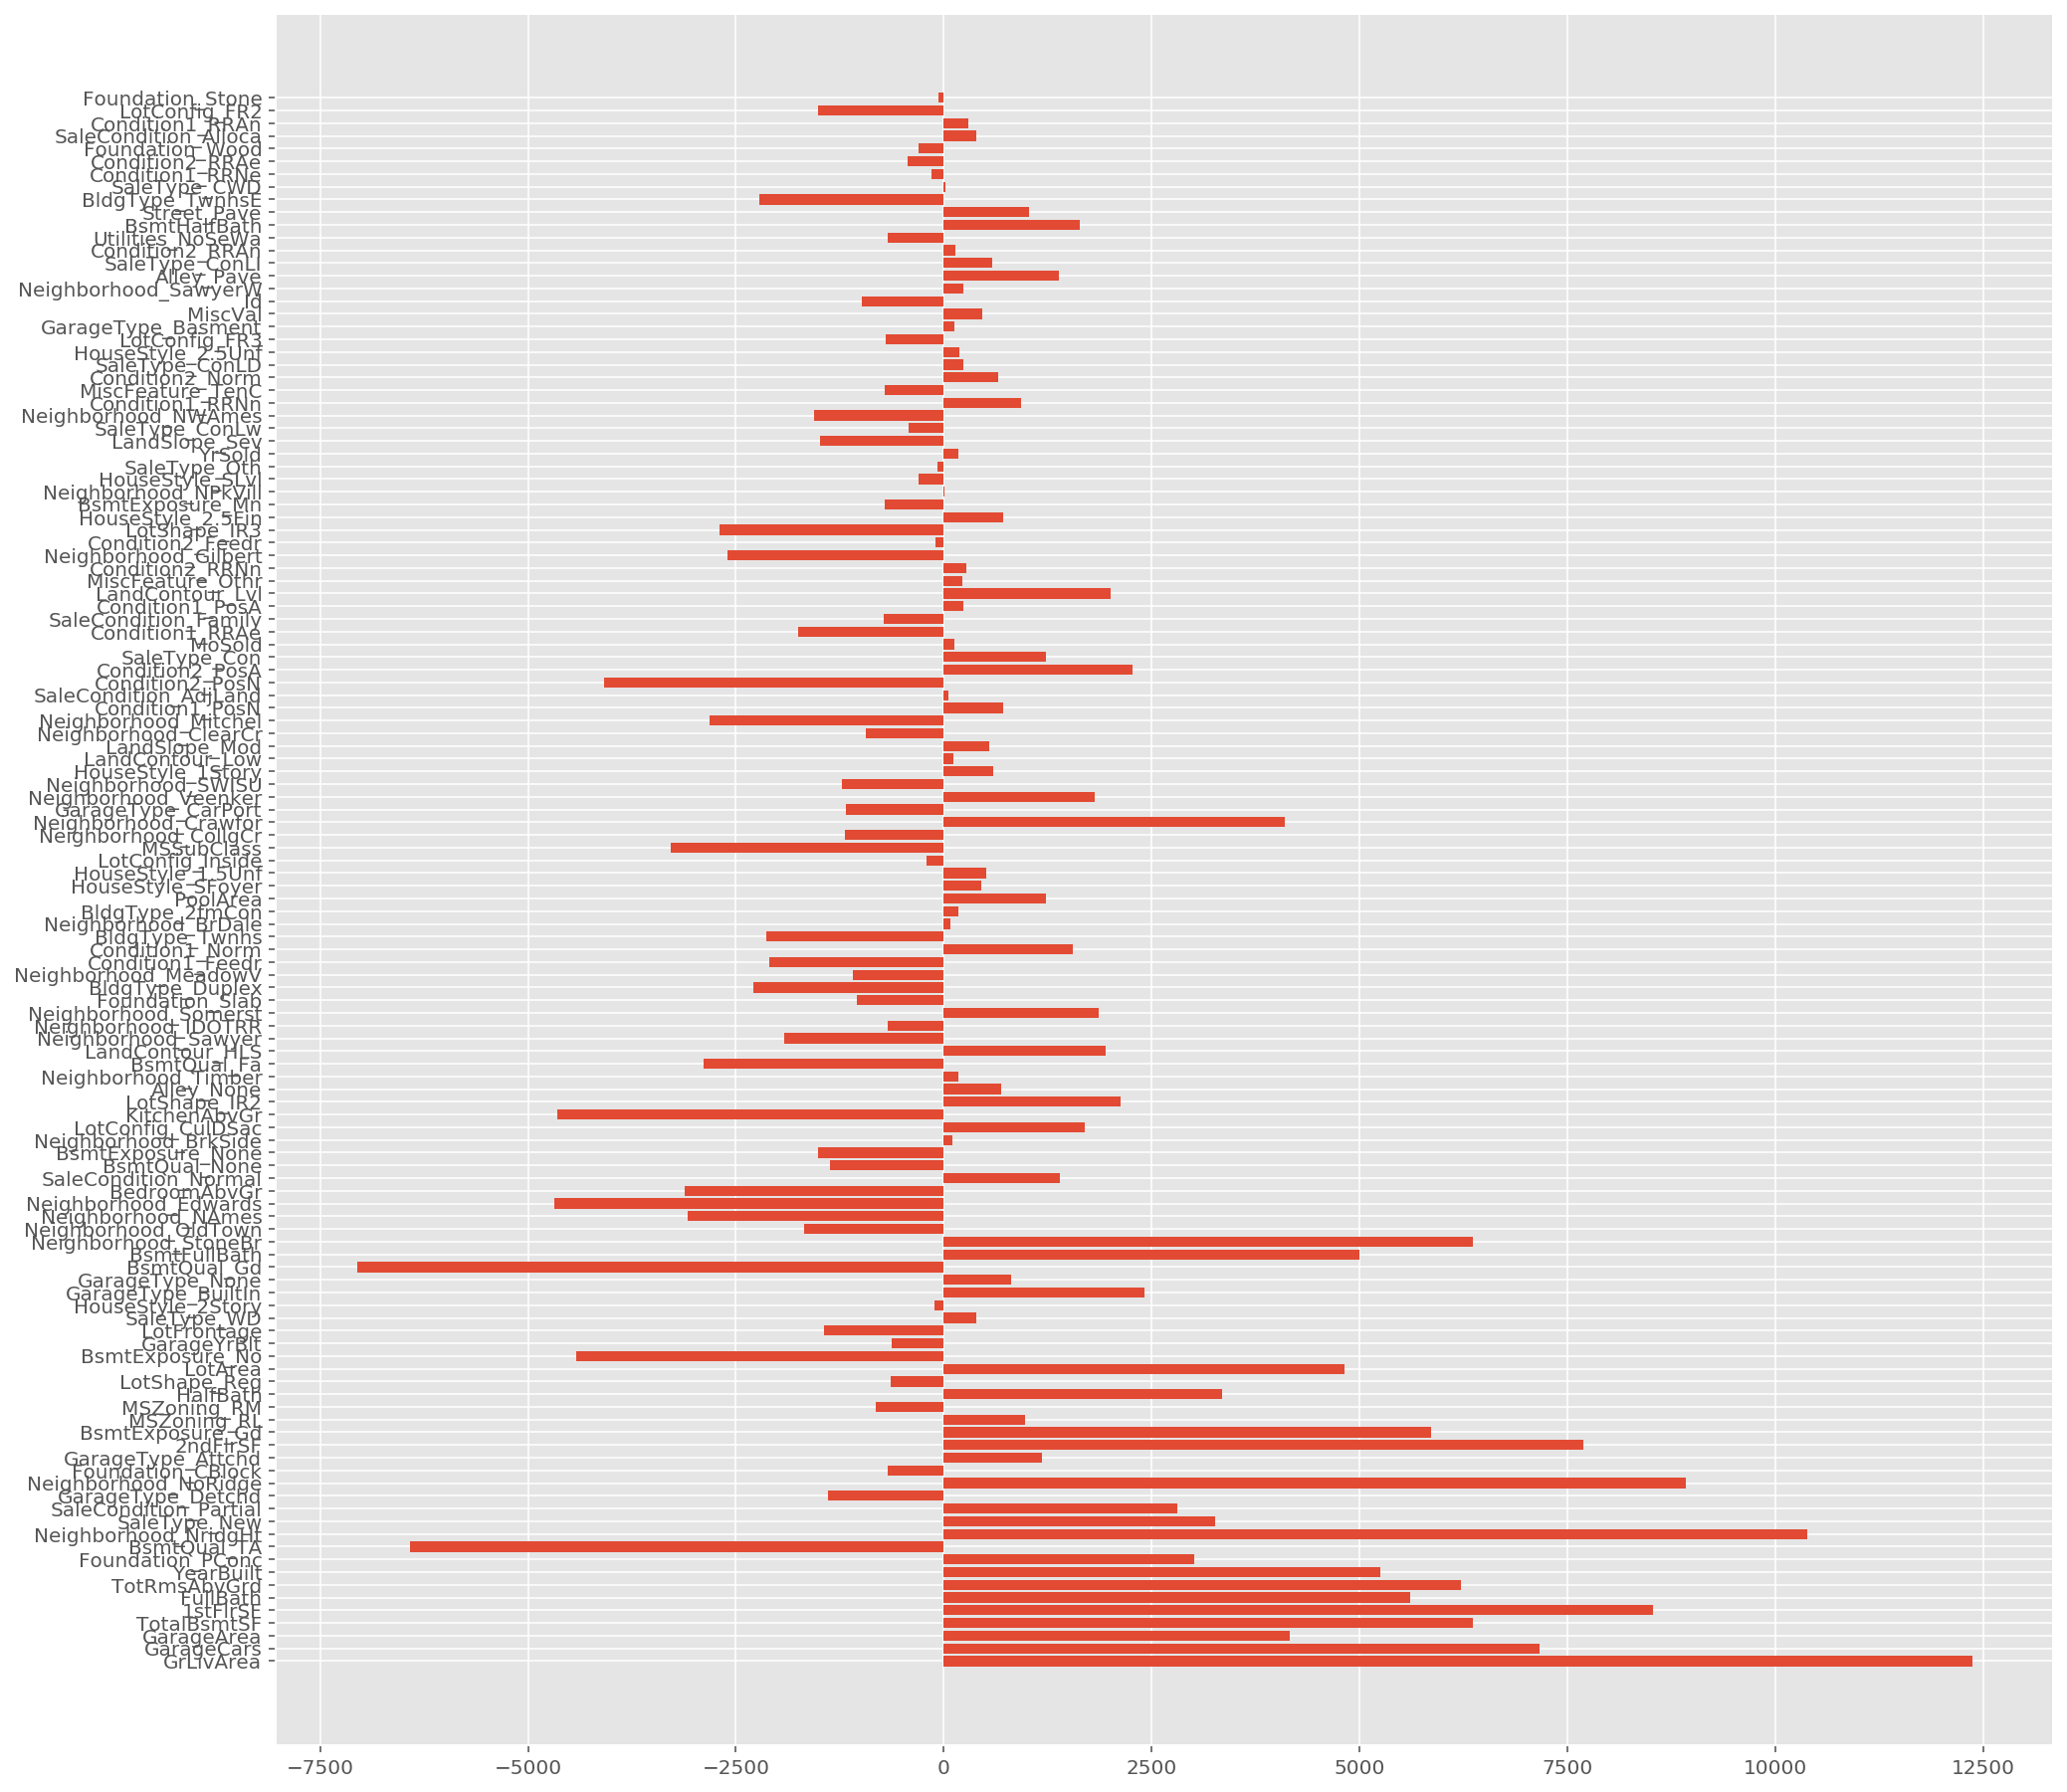

In [351]:
# Visualising the non-zero betas, they're largely to do with size of the house, garage, basement, and the YrBuilt
# Additionally there are a few neighbourhoods that can have a positive / negative effect on the price.

betas_plt = betas[betas['abs ElasticNet model.coef_'] > 0]

plt.figure(figsize=(16,16))
plt.barh(y=betas_plt.index,width=betas_plt['ElasticNet model.coef_']);

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [352]:
# A:
# model residuals:

X = pd.concat([X_train, X_test])
elastic.fit(X_train, y_train)

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24835837738.28064, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290998344154.565, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398823295534.1296, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303051372454.9326, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303012678750.70557, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302980882580.7622, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8569783341.319214, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332771995130.9856, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454309732379.28705, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420631503506.4901, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420610711719.6982, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420592834570.40985, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280974020244.4156, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297963345548.51605, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301664311067.0419, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381656615665.94495, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381626153346.1402, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381601350352.47266, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419650486981.07104, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420119103207.358, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420314900433.36993, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 633867023.9262695, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28838371672.53882, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160307139814.47464, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381703939491.8624, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381665181777.8621, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381632269389.34174, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414706956415.4443, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 416975846226.3043, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418135532848.28125, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118646367668.04062, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207196791090.02313, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254980025349.75504, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381379752482.95746, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381377959507.1442, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381374942595.2404, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408658378486.13293, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 410210432237.1948, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 411299595692.06836, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237359707394.34033, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252430649927.0542, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262250455160.20584, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379901802855.9481, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379958180819.9481, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380000995251.51013, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322934573787.8021, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335061435409.8052, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343818692126.7118, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 880998911.223999, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6636788771.355286, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26909052328.82013, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375007786674.95703, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375919907523.648, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376551254311.79236, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412189546784.4275, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1666570918.4074707, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8831417124.080933, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195649138005.0111, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207619185938.74985, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217036093919.43692, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183139377915.23486, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184757887636.35498, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186033102271.83963, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369121113857.1338, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369219946053.8061, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369297740116.5162, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45432248969.137695, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63156539725.68555, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80312148234.30121, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133930237165.65906, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139680810529.8629, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144299065390.4414, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119557456644.539, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120970880389.92834, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122092931452.14322, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355792043653.67175, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356047458935.0467, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356248280357.66516, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192822406807.94708, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193426385048.4422, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193906348322.85364, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3139457597.685669, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4921500272.921387, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6983882718.588013, tolerance: 616703133.5502684
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2556137197.164673, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4037767269.1257324, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5760146960.672974, tolerance: 584647184.4042102
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36516753182.84955, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69414638633.39069, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106299223661.95111, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275840336138.4897, tolerance: 612578979.3701819
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 686771565.2119141, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1592523436.4782715, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31052251583.324707, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31079846190.115112, tolerance: 668598108.8952768
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 736503613.8653564, tolerance: 621078183.3750088
  tol, rng, random, positive)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

ElasticNetCV(alphas=array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400829e-04, 6.57933225e-04, 8.30217568e-04,
       1.04761575e-03, 1.321941...
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05]),
             copy_X=True, cv=KFold(n_splits=5, random_state=1, shuffle=True),
             eps=0.001, fit_intercept=True,
             l1_ratio=[0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [353]:
y_train2 = y_train.reset_index()
elastic_resid = pd.concat([y_train2, pd.DataFrame(elastic.predict(X_train), columns=['ElasticPredict'], index=X_train.index)],axis=1)
elastic_resid['Residual'] = elastic_resid.apply(lambda x: x['SalePrice']-x['ElasticPredict'], axis=1)
elastic_resid['Residual %'] = elastic_resid.apply(lambda x: 100*x['Residual']/x['SalePrice'], axis=1)
elastic_resid

,index,SalePrice,ElasticPredict,Residual,Residual %
0,0.0,208500.0,209428.7,-928.7,-0.4
1,1.0,181500.0,201989.0,-20489.0,-11.3
2,2.0,223500.0,216173.5,7326.5,3.3
3,3.0,140000.0,196296.6,-56296.6,-40.2
4,4.0,250000.0,311946.4,-61946.4,-24.8
5,5.0,143000.0,157511.9,-14511.9,-10.1
6,6.0,307000.0,262419.5,44580.5,14.5
7,7.0,200000.0,220100.9,-20100.9,-10.1
8,8.0,129900.0,141761.0,-11861.0,-9.1
9,9.0,118000.0,98912.9,19087.1,16.2


In [354]:
elastic_resid.describe()
# the residuals have a mean = 0, but they vary for each observation.
# It could be useful to model these residuals vs. the changeable factors, to see how they vary with each variable.
# Thus getting a sense of which variables have had a bigger impact on the residual, e.g. the residual for 
# index 3 of the above df was quite large, which variable caused it to be so?

,index,SalePrice,ElasticPredict,Residual,Residual %
count,1221.0,1221.0,1221.0,1022.0,1022.0
mean,735.1,180447.3,180447.3,-118.1,-17.3
std,418.7,79760.2,69342.3,105080.2,73.1
min,0.0,37900.0,53640.0,-381072.1,-1005.5
25%,376.0,129500.0,129829.6,-58793.8,-43.1
50%,735.0,161000.0,167046.5,-309.1,-0.1
75%,1101.0,213000.0,216340.6,50380.7,27.3
max,1459.0,755000.0,528969.9,641173.4,84.9


In [358]:
X_changeable.head()

,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence
0,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,TA,GLQ,706,Unf,0,150,GasA,Ex,Y,SBrkr,0,Gd,Typ,0,None,RFn,TA,TA,Y,0,61,0,0,0,None,None
1,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,TA,ALQ,978,Unf,0,284,GasA,Ex,Y,SBrkr,0,TA,Typ,1,TA,RFn,TA,TA,Y,298,0,0,0,0,None,None
2,7,5,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,TA,GLQ,486,Unf,0,434,GasA,Ex,Y,SBrkr,0,Gd,Typ,1,TA,RFn,TA,TA,Y,0,42,0,0,0,None,None
3,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,Gd,ALQ,216,Unf,0,540,GasA,Gd,Y,SBrkr,0,Gd,Typ,1,Gd,Unf,TA,TA,Y,0,35,272,0,0,None,None
4,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,TA,GLQ,655,Unf,0,490,GasA,Ex,Y,SBrkr,0,Gd,Typ,1,TA,RFn,TA,TA,Y,192,84,0,0,0,None,None


In [360]:
# Set up the predictor, target variables.
# Then go through dummifying, scaling the X_changeable predictor matrix
# Need to use the index col in elastic_resid to construct the X_changeable matrix, then dummify / scale / model
X = X_changeable[X_changeable['YrSold'] != 2010]
y = elastic_resid['Residual']

In [361]:
print('X_changeable shape:',X.shape)
print('y (residuals) shape:',y.shape)

X_changeable shape: (1221, 38)
y (residuals) shape: (1420,)


In [362]:
# Dummify? then standardize then LinearReg:
X.select_dtypes(include=['object']).nunique()

RoofStyle        6
RoofMatl         8
Exterior1st     14
Exterior2nd     16
MasVnrType       4
ExterQual        4
ExterCond        4
BsmtCond         5
BsmtFinType1     7
BsmtFinType2     7
Heating          6
HeatingQC        5
CentralAir       2
Electrical       5
KitchenQual      4
Functional       7
FireplaceQu      6
GarageFinish     4
GarageQual       6
GarageCond       6
PavedDrive       3
PoolQC           4
Fence            5
dtype: int64

In [363]:
# Exteriors have a high nunique() counts, so perhaps don't need dummifying?
concat = pd.concat([X_changeable,y],axis=1)
Exterior1st = Exteriors[['Exterior1st','Residual']].groupby('Exterior1st').mean().reset_index().sort_values('Residual')
Exterior2nd = Exteriors[['Exterior2nd','Residual']].groupby('Exterior2nd').mean().reset_index().sort_values('Residual')

TypeError: 'AxesSubplot' object does not support item assignment

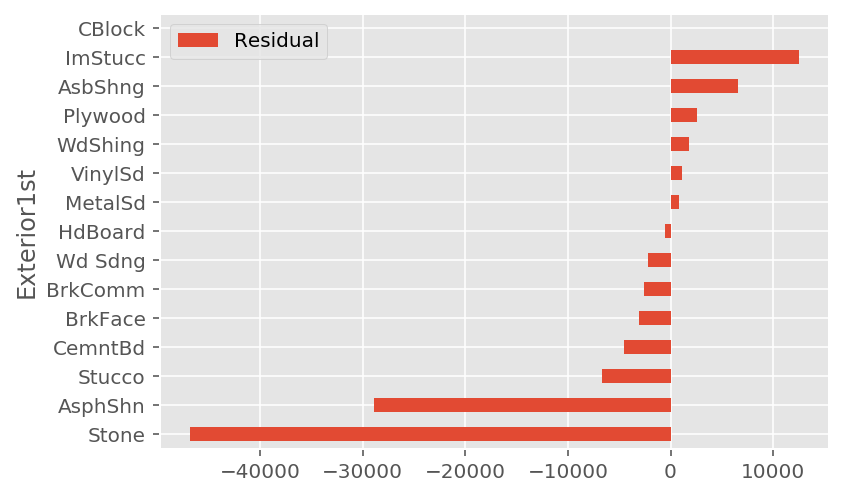

In [364]:
ax[0] = Exterior1st.plot.barh('Exterior1st', 'Residual');
ax[1] = Exterior2nd.plot.barh('Exterior2nd', 'Residual');
# These two parameters are predictive of residual so I will dummify

In [365]:
# plt.figure(figsize=(14,14))
# sns.heatmap(concat.corr(),vmin=-1,vmax=1,annot=True,fmt='.0')
# not very many changable attributes correlate that well with Residual

In [366]:
X_dum = pd.get_dummies(X,drop_first=True)

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_dum)     # call .fit_transform() method on X_train
X_train = pd.DataFrame(X_train_std,columns=X_dum.columns,index=X_dum.index)     # turn the standardized data into a dataframe

In [367]:
slr = LinearRegression()
slr.fit(X_train, y)

scores = cross_val_score(slr, X_train, y, cv=kf)
print(scores)
print(np.mean(scores))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [368]:
# Now see if we can improve betas with regularization:
elastic = ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     alphas=np.logspace(-5, 5, 100), cv=kf, max_iter=10000)
elastic.fit(X_train, y)
print(elastic.alpha_)
print(elastic.l1_ratio_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
print(elastic.alpha_)
print(elastic.l1_ratio_)

In [ ]:
enet = ElasticNet(alpha=elastic.alpha_, l1_ratio=elastic.l1_ratio_)
enet_scores = cross_val_score(enet, X_train, y, cv=kf)

print(enet_scores)
print(np.mean(enet_scores))
print(np.std(enet_scores))

# significant improvement after lasso regularization, the residuals can now be explained by my model trained on
# changeable parameters:

In [ ]:
# Let's chart the coefficents:
resid_betas = pd.concat([pd.Series(X_train.columns),pd.Series(elastic.coef_)],axis=1)
resid_betas.columns = ['Changeable','Coefs']
resid_betas['Abs_Coefs'] = resid_betas.Coefs.abs()
betas_plt = resid_betas[resid_betas['Coefs'] != 0].sort_values('Abs_Coefs',ascending=False)
betas_df = resid_betas[resid_betas['Coefs'] == 0].sort_values('Abs_Coefs',ascending=False)

plt.figure(figsize=(10,10))
plt.barh(y=betas_plt.Changeable, width=betas_plt.Coefs)

In [ ]:
# Perhaps not surprisingly the OverallQual of the house is the biggest renovatable driver of price, that's
# followed by the amount of Masonry Veneer, Basement Finish, # Fireplaces. The Exterior Quality was another big
# driver in price, namely that there was a reduction in price if it was only of Average quality.

In [ ]:
# So when choosing a property based on this second model, I would recommend opting for a property with low
# overall quality, mainly centered on the interiors, the bsmt, the masonry, and decent quality elsewhere.
# Ideally we'd want a property that doesn't need renovating apart from in those areas where we'd see an increase in 
# potential sale price.

In [ ]:
betas_df

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: